Kaggle compeetition for melanoma cancer detection competition from kaggle a good exercise for Convoutional neural Networks and image processing competition.


*   Some of the most important and noteworthy things has been done in this notebook. Linear image transformation and multiple models running in parrel on TPU as we have 7 cores and each core is assigned as each model. Without TPU this notebook will not work.



# Model results

Model name | AUC Score
--- | ---
VGG16 | 70.28
Inception | 67.00
VGG19 | 48.85
Xception | 82.21
Efficient net 6* | 87.3

* Also used label smoothing of 0.05.

# Import libraries

In [8]:
!pip install -U efficientnet

Requirement already up-to-date: efficientnet in /usr/local/lib/python3.7/dist-packages (1.1.1)


In [42]:
# Import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random
import matplotlib.pyplot as plt
import glob
import math
import tensorflow.keras.backend as K
import PIL
import seaborn as sns
from datetime import datetime
import efficientnet.keras as efn
from keras.applications import VGG16, ResNet101, ResNet50, InceptionV3, VGG19, ResNet152, Xception
import matplotlib.image as mpimg

# Intializing TPU or GPU

In [10]:
device = 'TPU'

In [11]:
# TPU and GPU mechanism
if device == 'TPU':
  print('Connecting to TPU')
  try:
    # Detects weather system has TPU.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU!', tpu.master())
  except ValueError:
    print('Could not connect to TPU.')
    tpu = None
  
  if tpu:
    try:
      print('Starting TPU')
      # Connects to the TPU cluster
      tf.config.experimental_connect_to_cluster(tpu)
      # Starts TPU cluster
      tf.tpu.experimental.initialize_tpu_system(tpu)
      # Object gives TPU cluster with 7 replicas
      strategy = tf.distribute.experimental.TPUStrategy(tpu)
      print('TPU started.')
    except:
      print('Failed to start TPU.')
  else:
    device = 'GPU'

# If no TPU then...
if device != 'TPU':
  print('Using single GPU and CPU.')
  strategy = tf.distribute.get_strategy()

if device == 'GPU':
  print(f'Number of GPU available: {len(tf.config.experimental.list_physical_devices("GPU"))}')

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'Replicas: {REPLICAS}')

Connecting to TPU
Running on TPU! grpc://10.27.192.170:8470
Starting TPU
INFO:tensorflow:Initializing the TPU system: grpc://10.27.192.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.27.192.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


TPU started.
Replicas: 8


# Initialize kaggle API function for submitting files to kaggle.

In [12]:
# This function will set kaggle API mostly colab and local machine specific
def kaggleAPI():
  # Install Kaggle API and get authentication
  ! pip install -q kaggle
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  try:
    ! ch mod 600 ~/.kaggle/kaggle.json
  except:
    print('Please download kagggle API and place in the same directory.')
  print('API installed and sorted.')
  print('Now you can submit results using API commands.')

# GCS file paths for kaggle competitions

In [13]:
TRAIN_GCS_PATH = 'gs://kds-aa955457fa616976a2911c5b9cd6a742d2b72c0d7755e82a48b7837e/jpeg/train/*.jpg'
TEST_GCS_PATH = 'gs://kds-aa955457fa616976a2911c5b9cd6a742d2b72c0d7755e82a48b7837e/jpeg/test/*.jpg'

## converting file paths in to list of file paths

In [14]:
trainFiles = tf.io.gfile.glob(TRAIN_GCS_PATH)
testFiles = tf.io.gfile.glob(TEST_GCS_PATH)
trainCSV = pd.read_csv('/content/drive/MyDrive/Melanoma/train.csv')
testCSV = pd.read_csv('/content/drive/MyDrive/Melanoma/test.csv')

# Data visualiztion

In [15]:
print(f'Training dataset has {len(trainFiles)} files.')
print(f'Test dataset has {len(testFiles)} files.')

Training dataset has 33126 files.
Test dataset has 10982 files.


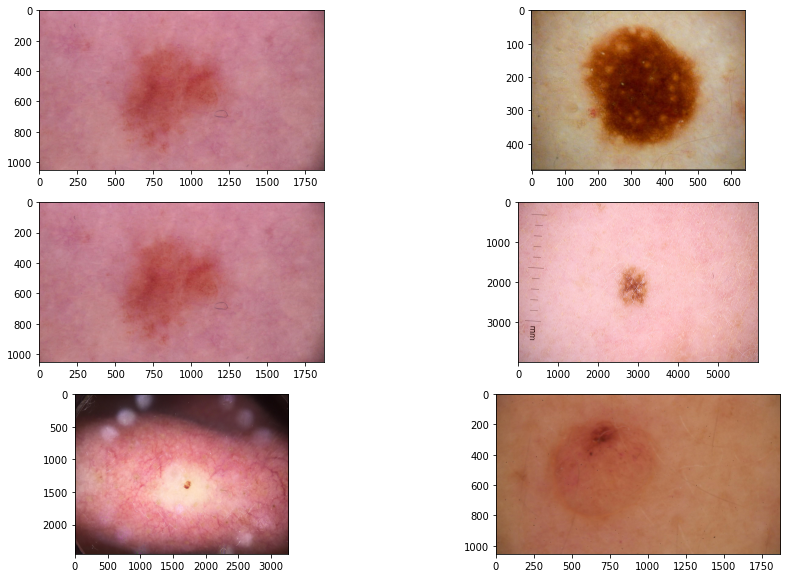

In [45]:
temp_path = '/content/drive/MyDrive/Melanoma/train/'
img1 = mpimg.imread(temp_path + 'ISIC_8973278.jpg')
img2 = mpimg.imread(temp_path + 'ISIC_2482653.jpg')
img3 = mpimg.imread(temp_path + 'ISIC_8973278.jpg')
img4 = mpimg.imread(temp_path + 'ISIC_0641973.jpg')
img5 = mpimg.imread(temp_path + 'ISIC_4573256.jpg')
img6 = mpimg.imread(temp_path + 'ISIC_2795397.jpg')
f, axis = plt.subplots(nrows=3, ncols=2, figsize=(15,10))
axis[0,0].imshow(img1)
axis[0,1].imshow(img2)
axis[1,0].imshow(img3)
axis[1,1].imshow(img4)
axis[2,0].imshow(img5)
axis[2,1].imshow(img6)
plt.show()

In [26]:
gender = trainCSV['sex'].value_counts().keys()
count = trainCSV['sex'].value_counts().values

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


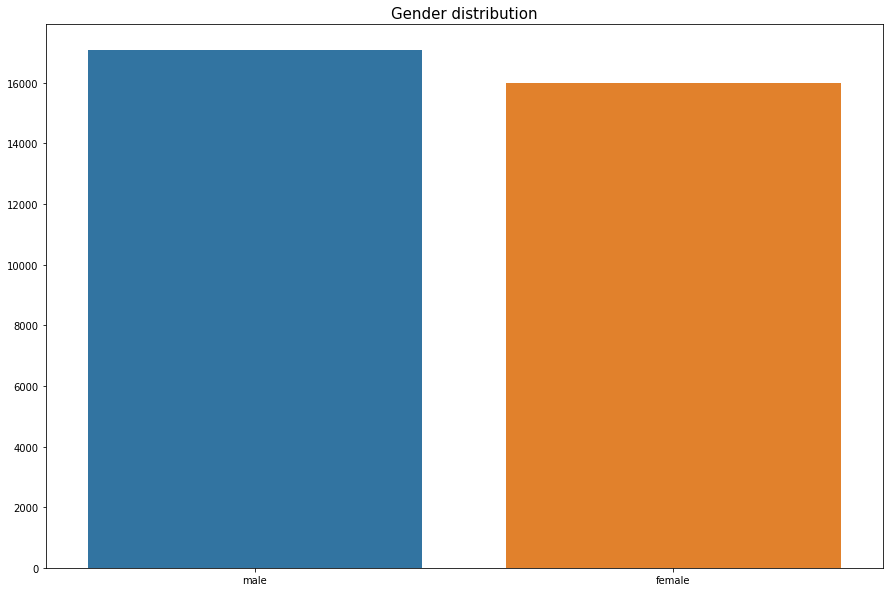

In [37]:
# sns.barplot(gender, count)
# plt.title('Gender counts')
# plt.xlabel('Gender', fon)
# plt.ylabel('Counts')
# plt.show()
f, axis = plt.subplots(figsize=(15,10))
sns.barplot(gender, count)
plt.title('Gender distribution', fontdict={'fontsize':'15'})
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


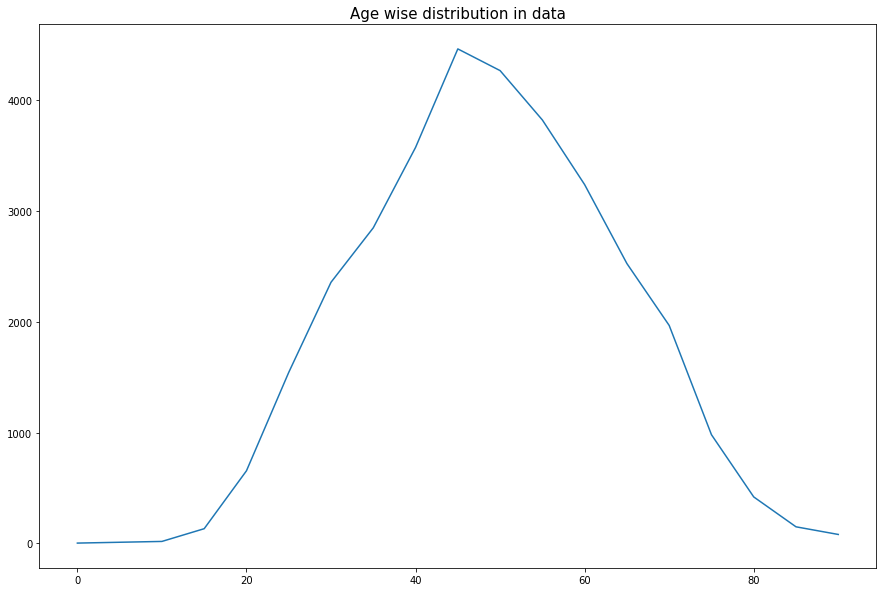

In [38]:
key = trainCSV['age_approx'].value_counts().keys()
value = trainCSV['age_approx'].value_counts().values
f, axis = plt.subplots(figsize=(15,10))
sns.lineplot(key, value, markers=True)
plt.title('Age wise distribution in data', fontdict={'fontsize':'15'})
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


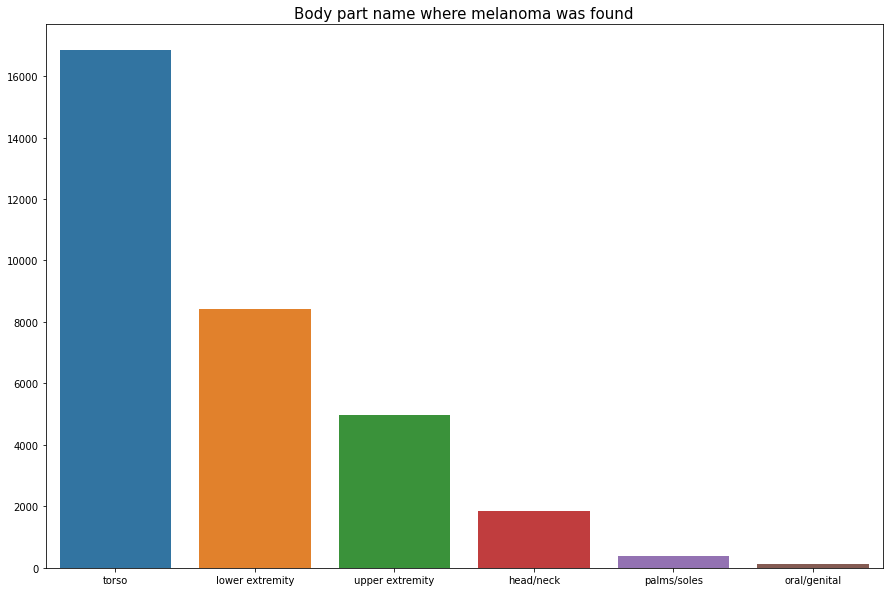

In [39]:
keys = trainCSV['anatom_site_general_challenge'].value_counts().keys()
values = trainCSV['anatom_site_general_challenge'].value_counts().values
f, axis = plt.subplots(figsize=(15,10))
sns.barplot(keys, values)
plt.title('Body part name where melanoma was found', fontdict={'fontsize':'15'})
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


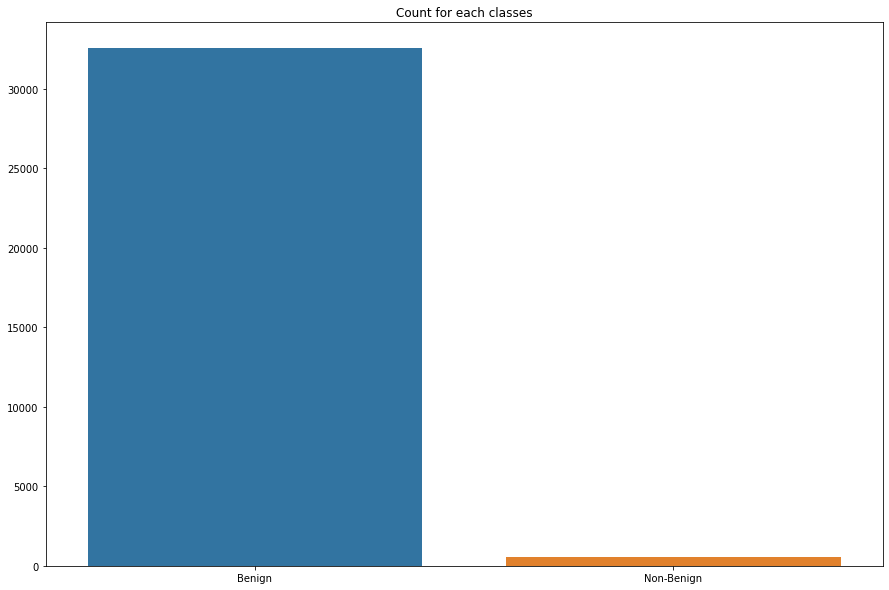

In [40]:
benign = len(trainCSV[trainCSV.target == 0])
nonBenign = len(trainCSV[trainCSV.target == 1])
keys = ['Benign', 'Non-Benign']
values = [benign, nonBenign]
f, axis = plt.subplots(figsize=(15,10))
sns.barplot(keys, values)
plt.title('Count for each classes')
plt.show()

# Data augmentation

## Get transformation matrix

In [8]:
def getMatrix(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
  # Convert data to radians
  rotation = math.pi * rotation / 180.0
  shear = math.pi * shear / 180.0

  def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
  # Rotation matrix
  c1   = tf.math.cos(rotation)
  s1   = tf.math.sin(rotation)
  one  = tf.constant([1],dtype='float32')
  zero = tf.constant([0],dtype='float32')
  
  rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                  -s1,  c1,   zero, 
                                  zero, zero, one])    
  # Shear matrix
  c2 = tf.math.cos(shear)
  s2 = tf.math.sin(shear)    
  
  shear_matrix = get_3x3_mat([one,  s2,   zero, 
                              zero, c2,   zero, 
                              zero, zero, one])        
  # Zoom matrix
  zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                              zero,            one/width_zoom, zero, 
                              zero,            zero,           one])    
  # Shift matrix
  shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                              zero, one,  width_shift, 
                              zero, zero, one])
  
  # This will generate dot prouct of all 4 of transformations
  return K.dot(K.dot(rotation_matrix, shear_matrix), 
                K.dot(zoom_matrix,     shift_matrix))

## Main transformation matrix for the image augmentation

List of transfromations will occues:


*   Rotation
*   Shear
*   Zoom
*   Shift

And this will be done by transform funnction all math functions will be performed in tensorflow numerical systems. So, by doinng that our TPU and tensorflow graph can be utilised.

After doing that augmented function will do extra transformation function. Extra list of transformations will be done as:


*   Ranndom flip horizonntally
*   Random hue
*   Random sturation
*   Random contrast
*   Random brightness





In [9]:
def transform(image, label=None):
  read_size = 256    
  rotation=180.0
  shear=2.0
  height_zoom=8.0
  width_zoom=8.0
  height_shift=8.0
  width_shift=8.0
  # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
  # output - image randomly rotated, sheared, zoomed, and shifted
  DIM = read_size
  XDIM = DIM%2 #fix for size 331
  
  rot = rotation * tf.random.normal([1], dtype='float32')
  shr = shear * tf.random.normal([1], dtype='float32') 
  h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / height_zoom
  w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / width_zoom
  h_shift = height_shift * tf.random.normal([1], dtype='float32') 
  w_shift = width_zoom * tf.random.normal([1], dtype='float32') 

  # GET TRANSFORMATION MATRIX
  m = getMatrix(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

  # LIST DESTINATION PIXEL INDICES
  x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
  y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
  z   = tf.ones([DIM*DIM], dtype='int32')
  idx = tf.stack( [x,y,z] )
  
  # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
  idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
  idx2 = K.cast(idx2, dtype='int32')
  idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
  
  # FIND ORIGIN PIXEL VALUES           
  idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
  d    = tf.gather_nd(image, tf.transpose(idx3))
  
  if label is not None: return tf.reshape(d,[DIM, DIM,3]), label
  else: return tf.reshape(d,[DIM, DIM,3])

## reading image file paths

In [10]:
# Decode image and labels from tensorflow dataset API
def decodeImageAndLabels(fileNames, label=None):
  # for reading files
  bits = tf.io.read_file(fileNames)
  # Decode image will convert whole file to numpy array of shape
  # Diving by 255 is only for normalizing numpy array to give values between 0 and 1
  # To do calculations easily
  bits = tf.image.decode_jpeg(bits, channels=3) / 255
  # Resize image with given image size
  image = tf.image.resize(bits, size=[256,256])
  if label is not None: return image, label
  else: return image

def augmented(image, label=None):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_hue(image, 0.01)
  image = tf.image.random_saturation(image, 0.7, 1.3)
  image = tf.image.random_contrast(image, 0.8, 1.2)
  image = tf.image.random_brightness(image, 0.1)
  if label is not None: return image, label
  else: return image

## decode image labels array

In [11]:
# Helper function will helps us to get target values which are 0 and 1
# we need to map file name with it's labels from pandas dataframe.
def decodeLabels(fileArray, pandasFile):
  result = []
  for x in fileArray:
    temp = x.split('/')[-1].split('.')[0]
    result.append(pandasFile[pandasFile['image_name']==temp]['target'].values[0])
  return result

In [12]:
# This call is very expensive, every file name there is call to pandas dataframe
# with search.
trainLabels = decodeLabels(trainFiles, trainCSV)

In [13]:
def getData(fileArray, labelArray=None, augment=True, repeat=True, shuffle=True, batch=True, batch_number=16, prefetch=True):
  if labelArray is not None:
    tensor = tf.data.Dataset.from_tensor_slices((fileArray, labelArray))
  else:
    tensor = tf.data.Dataset.from_tensor_slices(fileArray)
  tensor = tensor.cache()
  if repeat:
    tensor = tensor.repeat()
  if shuffle:
    # It shuffles as 8 times because there are 8 replicas
    tensor = tensor.shuffle(1024*8)
    opt = tf.data.Options()
    opt.experimental_deterministic = False
    tensor = tensor.with_options(opt)
  # tensor = tensor.map(decodeImageAndLabels, num_parallel_calls=AUTO)
  if augment:
    tensor = tensor.map(decodeImageAndLabels, num_parallel_calls=AUTO)
    tensor = tensor.map(transform, num_parallel_calls=AUTO)
    tensor = tensor.map(augmented, num_parallel_calls=AUTO)
  else:
    tensor = tensor.map(decodeImageAndLabels, num_parallel_calls=AUTO)
  if batch:
    tensor = tensor.batch(batch_number * REPLICAS)
  if prefetch:
    tensor = tensor.prefetch(AUTO)
  return tensor

# Testing of data augmentation pipelines

Testing of data pipelines with augmentation and without augmentationn.

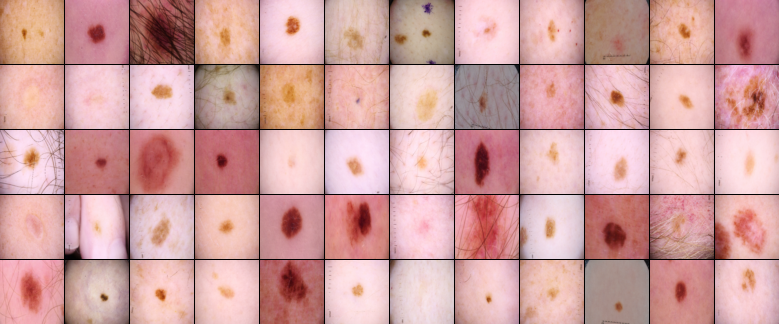

In [14]:
def show_dataset(thumb_size, cols, rows, ds):
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), 
                                             thumb_size*rows + (rows-1)))
   
    for idx, data in enumerate(iter(ds)):
        try:
          img, target_or_imgid = data
        except:
          img = data
        ix  = idx % cols
        iy  = idx // cols
        img = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
        img = PIL.Image.fromarray(img)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mosaic.paste(img, (ix*thumb_size + ix, 
                           iy*thumb_size + iy))


    display(mosaic)
    
ds = getData(trainFiles, trainLabels, shuffle=False, repeat=False, augment=False, prefetch=False).unbatch().take(12*5)
show_dataset(64, 12, 5, ds)

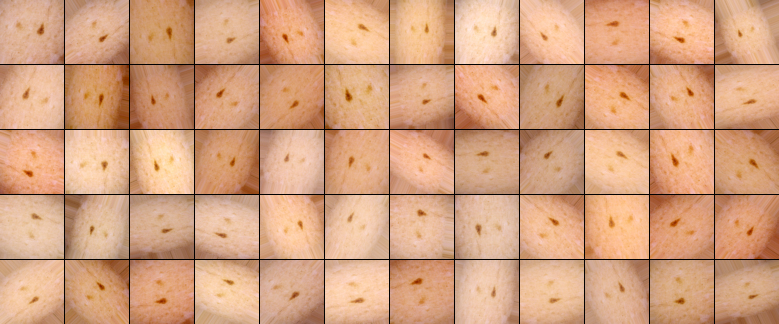

In [15]:
ds = getData([trainFiles[0]], [0], shuffle=False, repeat=True, augment=True, prefetch=False).unbatch().take(12*5)
show_dataset(64, 12, 5, ds)

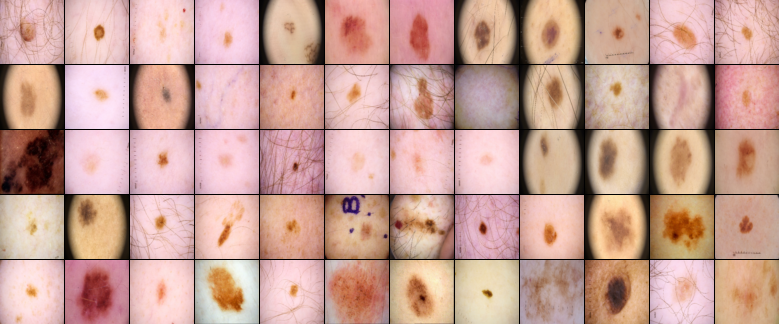

In [16]:
ds = getData(testFiles, shuffle=False, repeat=True, augment=False, prefetch=False).unbatch().take(12*5)
show_dataset(64, 12, 5, ds)

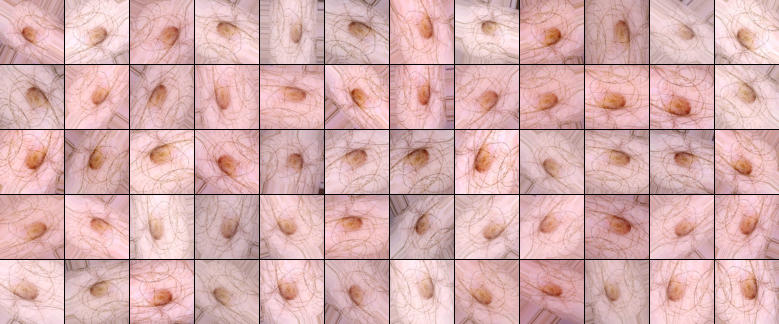

In [17]:
ds = getData([testFiles[0]], shuffle=False, repeat=True, augment=True, prefetch=False).unbatch().take(12*5)
show_dataset(64, 12, 5, ds)

This will generate model and single call will call 2 models or all models which we can call. Every epoch and everything will be generated in parallel in TPU.

In [18]:
def get_model():
  # Model input with pixel values
    model_input = tf.keras.Input(shape=(256, 256, 3), name='imgIn')

    dummy = tf.keras.layers.Lambda(lambda x:x)(model_input)
    
    models = ['ResNet50', 'InceptionResNetV2']    
    outputs = []
    for i in models:
        constructor = getattr(keras.applications, i)
        
        x = constructor(include_top=False, weights='imagenet', 
                        input_shape=(256, 256, 3), 
                        pooling='avg')(dummy)
        
        x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        outputs.append(x)
    model = tf.keras.Model(model_input, outputs, name='aNetwork')
    model.summary()
    return model

In [19]:
def compileNewModel():
  with strategy.scope():
    model = get_model()
    losses = [tf.keras.losses.BinaryCrossentropy() for i in range(2)]
    model.compile(optimizer=tf.optimizers.Adam(), loss=losses, metrics=[tf.keras.metrics.AUC(name='AUC')])
  return model

In [20]:
train = getData(trainFiles, trainLabels)
train = train.map(lambda img, label: (img, tuple([label]*2)))

In [ ]:
test = getData(testFiles, augment=False, repeat=False, shuffle=False)

In [ ]:
predicted = model.predict(test, verbose=1)

In [ ]:
predictFile(predicted[0])

In [17]:
train = getData(trainFiles, trainLabels)
train = train.map(lambda img, label: (img, tuple([label]*4)))

In [18]:
def get_model():
    model_input = tf.keras.Input(shape=(256, 256, 3), name='imgIn')

    dummy = tf.keras.layers.Lambda(lambda x:x)(model_input)
    
    models = ['VGG16', 'InceptionV3', 'VGG19', 'Xception']    
    outputs = []
    for i in models:
        constructor = getattr(keras.applications, i)
        
        x = constructor(include_top=False, weights='imagenet', 
                        input_shape=(256, 256, 3), 
                        pooling='avg')(dummy)
        
        x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        outputs.append(x)
    model = tf.keras.Model(model_input, outputs, name='aNetwork')
    model.summary()
    return model

In [19]:
def compileNewModel():
  with strategy.scope():
    model = get_model()
    losses = [tf.keras.losses.BinaryCrossentropy() for i in range(4)]
    model.compile(optimizer=tf.optimizers.Adam(), loss=losses, metrics=[tf.keras.metrics.AUC(name='AUC')])
  return model

In [20]:
model = compileNewModel()
history = model.fit(train, steps_per_epoch=255.40625, epochs=12, verbose=1)

Model: "aNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
imgIn (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           imgIn[0][0]                      
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 512)          14714688    lambda[0][0]                     
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 2048)         21802784    lambda[0][0]                     
___________________________________________________________________________________________

In [24]:
test = getData(testFiles, augment=False, repeat=False, shuffle=False)
# train = train.map(lambda img, label: (img, tuple([label]*4)))

In [26]:
predicted = model.predict(test, verbose=1)

86/86 [==============================] - 441s 5s/step


In [104]:
def predictFile(predictedArray, filePath = '/content/drive/MyDrive/Melanoma/sample_submission.csv'):
  sampleFile = pd.read_csv(filePath)
  testFileLabels = []
  for x in testFiles:
    testFileLabels.append(str(x.split('/')[-1].split('.')[0]))
  predictedArray = [predictedArray[x][0] for x in range(len(predictedArray))]
  predictedLabelsArray = dict(zip(testFileLabels, predictedArray))
  sampleFileNames = list(sampleFile['image_name'].values)
  sortedPredicted = []
  for x in sampleFileNames:
    sortedPredicted.append(predictedLabelsArray[x])
  sentFrame = pd.DataFrame({'image_name':sampleFileNames, 'target':sortedPredicted})
  fileName = str(datetime.today().strftime("%H:%M_%p")+'.csv')
  sentFrame.to_csv(fileName, index=False, sep=',')
  print('File Saved!')
  print(f'File name: {fileName}')

In [111]:
predictFile(predicted[0])

File Saved!
File name: 22:33_PM.csv


In [113]:
!kaggle competitions submit -c siim-isic-melanoma-classification -f 22:33_PM.csv -m "VGG16"

100% 359k/359k [00:01<00:00, 208kB/s]
Successfully submitted to SIIM-ISIC Melanoma Classification

In [114]:
# So far Xception is best with 85% accuracy

In [134]:
def get_model():
    model_input = tf.keras.Input(shape=(256, 256, 3), name='imgIn')

    dummy = tf.keras.layers.Lambda(lambda x:x)(model_input)
    
    outputs = []    
    for i in range(7):
        constructor = getattr(efn, f'EfficientNetB{i}')
        
        x = constructor(include_top=False, weights='imagenet', 
                        input_shape=(256, 256, 3), 
                        pooling='avg')(dummy)
        
        x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        outputs.append(x)
        
    model = tf.keras.Model(model_input, outputs, name='aNetwork')
    model.summary()
    return model

def compile_new_model():    
    with strategy.scope():
        model = get_model()
     
        losses = [tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.05)
                  for i in range(7)]
        
        model.compile(
            optimizer = tf.keras.optimizers.Adam(),
            loss      = losses,
            metrics   = [tf.keras.metrics.AUC(name='auc')])
        
    return model



In [135]:
train = getData(trainFiles, trainLabels)
train = train.map(lambda img, label: (img, tuple([label]*7)))

In [136]:
efModel = compileNewModel()
history = model.fit(train, steps_per_epoch=255.40625, epochs=12, verbose=1)

Model: "aNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
imgIn (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 256, 256, 3)  0           imgIn[0][0]                      
__________________________________________________________________________________________________
efficientnet-b0 (Functional)    (None, 1280)         4049564     lambda_4[0][0]                   
__________________________________________________________________________________________________
efficientnet-b1 (Functional)    (None, 1280)         6575232     lambda_4[0][0]                   
___________________________________________________________________________________________

In [ ]:
history.history

In [137]:
test = getData(testFiles, augment=False, repeat=False, shuffle=False)
# train = train.map(lambda img, label: (img, tuple([label]*4)))

In [138]:
predicted = model.predict(test, verbose=1)

86/86 [==============================] - 202s 2s/step


In [139]:
np.array(predicted).shape

(4, 10982, 1)

In [142]:
predictFile(predicted[-1])

File Saved!
File name: 03:35_AM.csv


In [143]:
!kaggle competitions submit -c siim-isic-melanoma-classification -f 03:35_AM.csv -m "Efficient Net 6 with label smoothing 0.05"

100% 371k/371k [00:01<00:00, 198kB/s]
Successfully submitted to SIIM-ISIC Melanoma Classification